# Fine Tuning do BERT no IMDB

Nome: Elton Cardoso do Nascimento

## Instruções:
> 
> 
> Treinar e medir a acurácia de um modelo BERT (ou variantes) para classificação binária usando o dataset do IMDB (20k/5k amostras de treino/validação).
> 
> Importante:
> - [x] Deve-se implementar o próprio laço de treinamento.
> - [x] Implementar o acumulo de gradiente.
> 
> Dicas:
> - BERT geralmente costuma aprender bem uma tarefa com poucas épocas (de 3 a 5 épocas). Se tiver demorando mais de 5 épocas para chegar em 80% de acurácia, ajuste os hiperparametros.
> 
> - Solução para erro de memória:
>   - [x] Usar bfloat16 permite quase dobrar o batch size
> 
> Opcional:
> - Pode-se usar a função trainer da biblioteca Transformers/HuggingFace para verificar se seu laço de treinamento está correto. Note que ainda assim é obrigatório implementar o laço próprio.

In [1]:
import os # Manipular arquivos
import random # Operações randômicas
import pickle # Serializar/deserializar backups
import time # Medição de tempo
import string # Operações com strings
from concurrent.futures import ThreadPoolExecutor # Parelização
from typing import Tuple, List, Dict, Optional # Type hints

import numpy as np # Operações vetoriais
import matplotlib.pyplot as plt # Plots
import tqdm
import torch # ML
from torch.utils.data import Dataset, DataLoader # Preparação de dados

try:
    import wandb # Logging
except:
    wandb = None

## Fixando a seed

In [2]:
def reset_seeds(seed:int=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
reset_seeds()

## Preparando Dados

> Primeiro, fazemos download do dataset:

In [4]:
if not os.path.isfile("aclImdb.tgz"):
    !curl -LO http://files.fast.ai/data/aclImdb.tgz
    !tar -xzf aclImdb.tgz

### Carregando o dataset

> Criaremos uma divisão de treino (20k exemplos) e validação (5k exemplos) artificialmente.

In [5]:
max_valid = 5000

In [6]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path), encoding="utf8") as f:
            texts.append(f.read())
    return texts

In [7]:
executor = ThreadPoolExecutor(max_workers=4)

folders = ['aclImdb/train/pos', 'aclImdb/train/neg', 'aclImdb/test/pos', 'aclImdb/test/neg']

futures = []
for folder in folders:
    future = executor.submit(load_texts, folder) 

    futures.append(future)

all_texts = []

for future in futures:
    texts = future.result()

    all_texts.append(texts)

executor.shutdown()

x_train_pos = all_texts[0]
x_train_neg = all_texts[1]
x_test_pos = all_texts[2]
x_test_neg = all_texts[3]


In [8]:
x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

In [9]:
# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

In [10]:
print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.


In [11]:
print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

3 primeiras amostras treino:
False POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. Int
False The long list of "big" names in this flick (including the ubiquitous John Mills) didn't bowl me over
True Bette Midler showcases her talents and beauty in "Diva Las Vegas". I am thrilled that I taped it and
3 últimas amostras treino:
False I was previously unaware that in the early 1990's Devry University (or was it ITT Tech?) added Film 
True The story and music (George Gershwin!) are wonderful, as are Levant, Guetary, Foch, and, of course, 
True This is my favorite show. I think it is utterly brilliant. Thanks to David Chase for bringing this i
3 primeiras amostras validação:
True Why has this not been released? I kind of thought it must be a bit rubbish since it hasn't been. How
True I was amazingly impressed by this movie. It contained fundamental elements of depression, grief, lon
True photography was too jumpy to follow. dark scenes hard to

In [4]:
GOOD_MOVIE = 1 #True
BAD_MOVIE = 0 #False

### Tokenizador

Preparamos o tokenizador para uso. No caso vamos utilizar o tokenizador preparado para o modelo BERT (é o mesmo do DistilBERT):

In [5]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

Using cache found in C:\Users\eltsu/.cache\torch\hub\huggingface_pytorch-transformers_main


Podemos testar o tokenizador imprimindo uma sequência (observe o token inicial "101"=CLS e final "102"=SEP):

In [14]:
tokens = tokenizer(x_train[0], add_special_tokens=True, padding="max_length", max_length=512)

tokens["input_ids"][:10], tokens["input_ids"][-10:]

([101, 153, 9025, 13882, 13360, 2036, 16625, 2346, 17656, 9637],
 [156, 2328, 12165, 2508, 1110, 1141, 10010, 10866, 119, 102])

In [6]:
BERT_SEP = 102

### Dataset e Dataloader

Definimos o dataset para realizar a tokenização e manipular os dados:

In [7]:
class IMDB_Dataset(Dataset):
    '''
    Dataset for sentiment analisys

    Input: tokenized review and mask (for padding).
    Output: if is a good (1) or bad (0) review. 
    '''
    def __init__(self, x_data:List[str], y_data:List[bool], tokenizer) -> None:
        """
        Creates a new dataset.

        Args:
            x_data (List[str]): dataset reviews.
            y_data (List[bool]): dataset targets.
            tokenizer: tokenizer to encode reviews.

        """

        super().__init__()

        self._x_data = tokenizer(x_data, 
                                 return_tensors="pt", #Return as torch tensor 
                                 padding=True, #Add padding to small sequences
                                 return_token_type_ids=False, #Don't return sequence mask (only one sequence)
                                 truncation=True) #Truncate big sentences (max = 512 tokens, with CLS and SEP)

        self._y_data = torch.tensor(y_data, dtype=torch.float32)

        self._size = len(self._y_data)
        
        self.max_len = 512


    def __len__(self) -> int:
        """
        Gets the size of the dataset.

        Returns:
            int: dataset size.
        """

        return self._size
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Gets a item of the dataset.

        Args:
            idx (int): data index.

        Returns:
            torch.Tensor: dataset input.
            torch.Tensor: dataset attention mask. 
            torch.Tensor: dataset target.
        """
        x_data = self._x_data["input_ids"][idx]
        mask = self._x_data["attention_mask"][idx]
        
        if self.max_len != 512:
            x_data = x_data[:self.max_len]
            x_data[-1] = BERT_SEP

            mask = mask[:self.max_len]


        return x_data, mask, self._y_data[idx]

In [ ]:
datasets = {}

xs = [x_train, x_valid, x_test]
ys = [y_train, y_valid, y_test]
names = ["train", "val", "test"]

for i in range(3):
    dataset = IMDB_Dataset(xs[i], ys[i], tokenizer)
    datasets[names[i]] = dataset

Para evitar precisamos realizar várias vezes a tokenização durante o desenvolvimento, podemos serializar o dataset para posteriormente deserializá-lo:

In [18]:
file_name = "datasets.bin"
with open(file_name, "wb") as file:
    pickle.dump(datasets, file)

In [9]:
file_name = "datasets.bin"

with open(file_name, "rb") as file:
    datasets = pickle.load(file)

E defimos uma função para criar os dataloaders a partir dos datasets e batch size:

In [10]:
def create_dataloaders(datasets:Dict[str, Dataset], batch_size:int) -> Dict[str, DataLoader]:
    '''
    Generate dataloaders from datasets.

    Args:
        datasets (Dict[str, Dataset]): named datasets.
        batch_size (int): batch sizes.

    Returns:
        Dict[str, DataLoader]: dataloaders for the datasets.
    '''


    dataloaders = {}

    for name in datasets:
        dataloaders[name] = DataLoader(datasets[name], batch_size=batch_size, shuffle=True)
    
    return dataloaders

E uma função para alterar o tamanho das sequências que serão geradas:

In [11]:
def set_max_len(datasets:Dict[str, IMDB_Dataset], max_len):
    for name in datasets:
        datasets[name].max_len = max_len

## Preparação do modelo

Prepamos o modelo a ser utilizado, que é um modelo BERT com uma camada adicional para realizar a classificação, que recebe como entrada o embedding final relacionado ao token CLS:

In [12]:
class BinaryClassifierBERT(torch.nn.Module):
    '''
    Classifier model using BERT.
    '''

    def __init__(self, dropout_rate:float=0) -> None:
        '''
        Model constructor.

        Args:
            dropout_rate (float, optional): Dropout before the final layer. Defaults to 0.
        '''
        super().__init__()
        
        self.bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-cased')
        
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.linear = torch.nn.Linear(768, 1)

    def forward(self, input_ids:torch.Tensor, attention_masks:Optional[torch.Tensor]=None) -> torch.Tensor:
        '''
        Computes the classification for the input.

        Args:
            input_ids (torch.Tensor): tokenized input.
            attention_masks (torch.Tensor, optional): attention mask of the input. Defaults to None.

        Returns:
            torch.Tensor: inference result.
        '''
        
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_masks)
        c_vector = bert_output.last_hidden_state[:, 0]

        y = self.dropout(c_vector)
        y = self.linear(y)

        return y

## Treino

Nesta seção iremos realizar o treino, iniciando pela definição de algumas funções auxiliares.

### Funções auxiliares

Iremos definir três funções auxiliares: uma para calcular a perplexidade a partir da loss, outra para printar informações e uma final para calcular a loss:

In [13]:
def ppl(loss:torch.Tensor) -> torch.Tensor:
    """
    Computes the perplexity from the loss.

    Args:
        loss (torch.Tensor): loss to compute the perplexity.

    Returns:
        torch.Tensor: corresponding perplexity.
    """
    return torch.exp(loss)

In [14]:
def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, 
               time:float=0.0, accuracy:Optional[float]=None):
    """
    Prints the information of a epoch.

    Args:
        loss_value (torch.Tensor): epoch loss.
        epoch (int): epoch number.
        total_epochs (int): total number of epochs. 
        time (float, optional): time to run the epoch. Don't print if is 0.0. Defaults to 0.0.
        accuracy (float, optional): epoch accuracy.
    """
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if accuracy is not None:
        print(f', Accuracy: {100*accuracy:.4f}%')

    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")

In [15]:
MODE_TRAIN = 0
MODE_EVALUATE = 1

In [16]:
def compute_loss(model:torch.nn.Module, loader:DataLoader, 
                 criterion:torch.nn.Module, mode:int = MODE_EVALUATE, 
                 optimizer:Optional[torch.optim.Optimizer]=None, 
                 accumulation_steps:Optional[int] = 1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the loss from a model across a dataset.

    If in train mode also runs optimizer steps.

    Args:
        model (torch.nn.Module): model to evaluate.
        loader (DataLoader): dataset.
        criterion (torch.nn.Module): loss function to compute.
        mode (int): mode of the computation. 
                    If MODE_EVALUATE, computes without gradient, in eval mode and detachs loss.
                    If MODE_TRAIN, computes with gradient and in train mode.
                    Default is MODE_EVALUATE.
        optimizer (torch.optim.Optimizer, optional): optimizer to use in the train mode.

    Returns:
        torch.Tensor: resulting loss.
        torch.Tensor: resulting accuracy
    """
    device = next(iter(model.parameters())).device

    if mode == MODE_EVALUATE:
        model.eval()
        torch.set_grad_enabled(False)
    elif mode == MODE_TRAIN:
        model.train()
        torch.set_grad_enabled(True)
        optimizer.zero_grad()
    else:
        raise ValueError(f"Unknown mode: {mode}.")

    batch_index = 0
    total_loss = torch.tensor(0, dtype=torch.float32, device=device)
    correct = torch.tensor(0, dtype=torch.float32, device=device)
    n = 0
    for inputs, masks, targets in tqdm.tqdm(loader):
        inputs = inputs.to(device)
        masks = masks.to(device)

        targets = targets.reshape(-1)
        targets = targets.to(device)
        
        logits = model(inputs, masks)
        logits = logits.view(-1, logits.shape[-1])

        loss : torch.Tensor = criterion(logits.squeeze(), targets)
        total_loss += loss*targets.size(0)
        
        predicted = torch.round(torch.sigmoid(logits.squeeze()))
        correct += (predicted == targets).sum().item()

        n += targets.size(0)

        if mode == MODE_TRAIN:
            loss /= accumulation_steps
            loss.backward()

            if ((batch_index+1) % accumulation_steps == 0) or (batch_index+1 == len(loader)):
                optimizer.step()
                optimizer.zero_grad()

        batch_index += 1

    total_loss /= n 
    accuracy = correct / n
    
    torch.set_grad_enabled(True)

    accuracy = accuracy.detach()
    total_loss = total_loss.detach()

    return total_loss, accuracy


### Inicialização

Começamos o processo de treino inicializando as variáveis.

Definimos se será realizado o logging utilizando o wandb:

In [17]:
use_wandb = True

Checamos se existe uma GPU disponível:

In [18]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Definimos os parâmetros de treino. No caso os parâmetros a seguir são do melhor treino, enquanto que todas as variações testadas podem ser encontradas em [https://api.wandb.ai/links/eltoncn/2exfkyeh](https://api.wandb.ai/links/eltoncn/2exfkyeh).

In [29]:
accumulation_steps = 2 # Passos de acumulação de gradiente
batch_size = 16 # Tamanho de um batch
dropout_rate = 0.1 # Taxa de dropout para a camada adicional
lr = 2.5e-5 # Taxa de treinamento
n_epoch = 5 # Quantidade de epochs
optimizer_class = torch.optim.Adam # Otimizador
seq_len = 512 # Tamanho de uma sequência
weight_decay = 0 # Regularização L2

config = {
    "accumulation_steps": accumulation_steps,
    "batch_size": batch_size,
    "dropout_rate": dropout_rate,
    "lr": lr,
    "n_epoch": n_epoch,
    "optimizer_class": optimizer_class.__name__,
    "seq_len" : seq_len,
    "weight_decay": weight_decay,
}

if use_wandb:
    run = wandb.init(project="IA024-04-BERT_IMDB", config=config)
    run_name = run.name
    run_id = run.id
    model_name = f"{run_name}-{run_id}.bin"
else:
    #get random name using config
    seed = 0
    for name in config:
        if isinstance(config[name], int) or isinstance(config[name], float):
            seed += config[name]
        else:
            for c in config[name]:
                seed += ord(c)

    reset_seeds(seed)
    model_name = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))

Reiniciamos as sementes:

In [30]:
reset_seeds()

Criamos o modelo, loss, otimizador e dataloaders:

In [31]:
model = BinaryClassifierBERT(dropout_rate)
model.to(device, dtype=torch.bfloat16)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

set_max_len(datasets, seq_len)
dataloaders = create_dataloaders(datasets, batch_size)

Using cache found in C:\Users\eltsu/.cache\torch\hub\huggingface_pytorch-transformers_main


### Treino

E finalmente podemos realizar o processo de treino em si:

In [32]:
#Informações antes da primeira epoch
prev_loss, prev_accuracy = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
print_info(prev_loss, -1, n_epoch, 0, prev_accuracy)

100%|██████████| 313/313 [01:31<00:00,  3.41it/s]

Epoch [0/5],             Loss: 0.7207,             Perplexity: 2.0559, Accuracy: 49.4600%



In [33]:
hist = {}
hist["loss_train"] = []
hist["loss_val"] = []
hist["ppl_train"] = []
hist["ppl_val"] = []
hist["accuracy_train"] = []
hist["accuracy_val"] = []

for epoch in range(n_epoch):
    start_time = time.time() 

    loss_train, accuracy_train = compute_loss(model, dataloaders["train"], criterion, MODE_TRAIN, optimizer, accumulation_steps)

    end_time = time.time() 
    
    epoch_duration = end_time - start_time 

    ppl_train = ppl(loss_train)

    print_info(loss_train, epoch, n_epoch, epoch_duration, accuracy_train)
    
    #Validation stats
    loss_val, accuracy_val = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
    ppl_val = ppl(loss_val)
    
    print("VAL ", end="")
    print_info(loss_val, epoch, n_epoch, accuracy=accuracy_val)

    #Save history
    hist["loss_train"].append(loss_train.item())
    hist["loss_val"].append(loss_val.item())
    hist["ppl_train"].append(ppl_train.item())
    hist["ppl_val"].append(ppl_val.item())
    hist["accuracy_train"].append(accuracy_train.item())
    hist["accuracy_val"].append(accuracy_val.item())

    log = {
        "loss_train": loss_train.item(),
        "loss_val": loss_val.item(),
        "ppl_train": ppl_train.item(),
        "ppl_val": ppl_val.item(),
        "accuracy_train": accuracy_train.item(),
        "accuracy_val": accuracy_val.item()
    }

    if use_wandb:
        wandb.log(log)

for key in hist:
    hist[key] = np.array(hist[key])

if use_wandb:
    wandb.finish()

100%|██████████| 1250/1250 [16:49<00:00,  1.24it/s]


Epoch [1/5],             Loss: 0.3495,             Perplexity: 1.4183, Accuracy: 83.9650%
, Elapsed Time: 1010.84 sec


100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


VAL Epoch [1/5],             Loss: 0.2565,             Perplexity: 1.2923, Accuracy: 89.6200%



100%|██████████| 1250/1250 [16:01<00:00,  1.30it/s]


Epoch [2/5],             Loss: 0.2370,             Perplexity: 1.2675, Accuracy: 90.5150%
, Elapsed Time: 962.81 sec


100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


VAL Epoch [2/5],             Loss: 0.2462,             Perplexity: 1.2791, Accuracy: 90.4800%



100%|██████████| 1250/1250 [16:32<00:00,  1.26it/s]


Epoch [3/5],             Loss: 0.2137,             Perplexity: 1.2382, Accuracy: 91.5900%
, Elapsed Time: 993.92 sec


100%|██████████| 313/313 [01:27<00:00,  3.58it/s]


VAL Epoch [3/5],             Loss: 0.2374,             Perplexity: 1.2680, Accuracy: 90.6200%



100%|██████████| 1250/1250 [16:47<00:00,  1.24it/s]


Epoch [4/5],             Loss: 0.1924,             Perplexity: 1.2121, Accuracy: 92.6150%
, Elapsed Time: 1008.03 sec


100%|██████████| 313/313 [01:26<00:00,  3.62it/s]


VAL Epoch [4/5],             Loss: 0.2417,             Perplexity: 1.2734, Accuracy: 90.7400%



100%|██████████| 1250/1250 [16:27<00:00,  1.27it/s]


Epoch [5/5],             Loss: 0.1758,             Perplexity: 1.1922, Accuracy: 93.4500%
, Elapsed Time: 988.82 sec


100%|██████████| 313/313 [01:28<00:00,  3.54it/s]

VAL Epoch [5/5],             Loss: 0.2427,             Perplexity: 1.2747, Accuracy: 90.7600%



accuracy_train,▁▆▇▇█
accuracy_val,▁▆▇██
loss_train,█▃▃▂▁
loss_val,█▄▁▃▃
ppl_train,█▃▂▂▁
ppl_val,█▄▁▃▃
accuracy_train,0.9345
accuracy_val,0.9076
loss_train,0.17581
loss_val,0.24274
ppl_train,1.19221


Plotamos os gráficos das estatísticas obtidas durante o treinamento, onde podemos observar que o modelo conseguiu treinar corretamente, visto que as métricas melhoram pelas épocas; porém com overfitting, já que existe uma discrepância com estagnação ou piora nas métricas de validação:

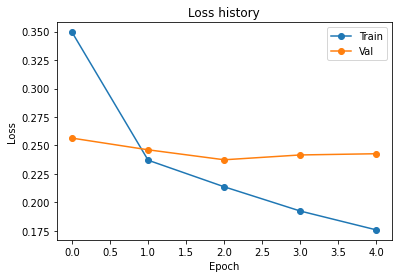

In [34]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

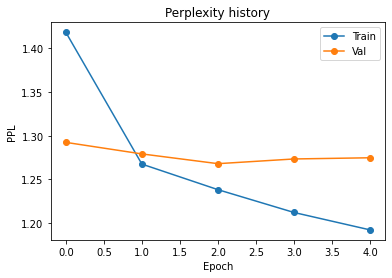

In [35]:
plt.plot(hist["ppl_train"], "o-")
plt.plot(hist["ppl_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("PPL")
plt.title("Perplexity history")

plt.show()

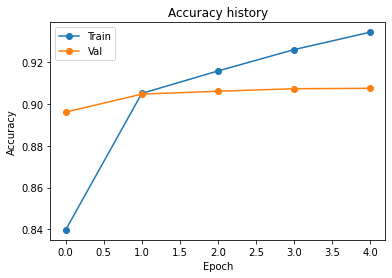

In [36]:
plt.plot(hist["accuracy_train"], "o-")
plt.plot(hist["accuracy_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy history")

plt.show()

E podemos por fim salvar o modelo para uso posterior:

In [37]:
torch.save(model, model_name)

## Avaliação

Para avaliação começamos calculando as estatísticas no dataset de teste:

In [38]:
test_loss, test_accuracy = compute_loss(model, dataloaders["test"], criterion, mode=MODE_EVALUATE)
test_ppl = ppl(test_loss)

test_loss.item(), test_ppl.item(), test_accuracy.item()

100%|██████████| 1563/1563 [07:17<00:00,  3.57it/s]


(0.2271283119916916, 1.2549909353256226, 0.9109199643135071)

Calculamos quantos pesos adicionais foram necessários:

In [39]:
n_param_bert = sum([p.numel() for p in model.bert.parameters()])

n_param = sum([p.numel() for p in model.parameters()])
n_param-n_param_bert, (n_param-n_param_bert)/n_param_bert

(769, 1.1796122747906947e-05)

E verificamos qualitativamente a saída do modelo:

In [40]:
tokens = tokenizer('''This must be gambling debt. Because only when someone threatens to break your legs 
                      if you don't pay will you go and agree to make a film like this.''', 
                    return_tensors="pt",
                    return_token_type_ids=False,
                    truncation=True,)

with torch.no_grad():
    logits = model(tokens["input_ids"].to(device), tokens["attention_mask"].to(device))

print("Result:", logits.item())
print(f"Is this a good movie? {torch.round(logits).item() == GOOD_MOVIE}")

Result: -2.6875
Is this a good movie? False


Podemos observar que ele realizou corretamente a classificação